# MELC 496 Text Analysis Tutorial

This tutorial will introduce how to perform textual analysis using Python and a historical corpus, the Svoboda diaries. To run this tutorial, you will need to have some fundamental
data science and machine learning libraries installed (e.g., pandas, numpy, sklearn, matplotlib, seaborn).

You will also want to have the Svoboda diaries corpus downloaded and in a folder on your computer. Make a note of this location, as you will need to enter it below.

If you do not know how to use Jupyter Notebook, this page may be helpful: https://www.dataquest.io/blog/jupyter-notebook-tutorial/

For questions, contact: atchen@uw.edu.

In [1]:
# packages to store and manipulate data
import pandas as pd
import numpy as np

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# model building package
import sklearn

# package to clean text
import re

# package to perform operating system functions, like obtaining the location of a file
import os

In [2]:
# set data_dir to the path on your computer where you have the files from the Svoboda diaries corpus
data_dir = "/Users/annietchen/PycharmProjects/sdp_network/data/annotatable_entries/47"

## Read in the corpus

Let's begin by ingesting the corpus. We create a function called, "read_files" which reads in all of the files in the directory and puts them in a data structure called a "dataframe". The files in this directory have a special naming convention that enables us to identify the year, month, and date of each diary entry, as well as order the diary entries sequentially.

Read_files "ingests" all of the files in the specified directory and then returns a dataframe in which each row represents a day in the diary, and it is possible to retrieve diary entries by date.

In [3]:
def read_files(data_dir):
    """
    Read all of the files in a directory into a list.

    :param data_dir: directory to ingest
    :return: dataframe of files in the directory
    """
    import os
    import pandas as pd
    import matplotlib.pyplot as plt

    month_dict = {"Jan": 1, "Feb": 2, "Mch": 3, "Apr": 4, "May": 5, "Jun": 6, "July": 7, "Augt": 8, "Sept": 9, "Oct": 10, "Novr": 11, "Decr": 12}

    index_list = []
    year_list = []
    month_list = []
    day_list = []
    entry = []
    entry_list = []

    # obtain a list of the files in this directory, sorted in ascending order
    entry_filenames = sorted(os.listdir(data_dir))

    # loop through directory and construct a list containing the text from each of the entries
    for entry_filename in entry_filenames:
        # construct list of days
        index = int(entry_filename.split('_')[0])
        year = int(entry_filename.split('_')[1])
        month = month_dict[entry_filename.split('_')[2]]
        date = int(entry_filename.split('_')[3])

        # read in entries
        with open(data_dir + "/" + entry_filename, "r") as entry_file:
            entry_text = entry_file.read()

        # append day metadata and entry
        entry_list.append([index, year, month, date, entry_text])

    # convert to dataframe and sort in ascending order by day
    entries_df = pd.DataFrame(entry_list, columns=['day', 'year', 'month', 'date', 'text'])
    entries_sorted_df = entries_df.sort_values(by='day', ascending = True).reset_index(drop=True)

    return entries_sorted_df

In [4]:
# call the read_files function to read all of the entries in the corpus (diary 47 of the Svoboda Diaries)
entries = read_files(data_dir)

In [5]:
# take a look at the first few entries
entries.head()

,day,year,month,date,text
0,1,1897,11,4,4 Thursd The @ 6.62 1897 Novr Light N.W. & fin...
1,2,1897,11,5,5 Frid Light N.W. & fine weather at 4 am I cam...
2,3,1897,11,6,6 Satur Light S. Ely breeze & cloudy a little\...
3,4,1897,11,7,7 Sund. 1897 Novr Light air & getting fine~ At...
4,5,1897,11,8,8 Mond The @ 6.60 Eliza’s arrival from Paris [...


In [6]:
# How many entries do we have?
len(entries)

273

## Count of Occurrences

In this next part, we will first define a function that finds all occurrences of a text string in the corpus, and returns only the rows containing that text string. Then, we can count and plot them by month.

In [7]:
def find_string_occurrences(df, column_name, search_string):
    """
    Finds all occurrences of a string in a DataFrame column and returns a list of indices for each row.

    Args:
        df (pd.DataFrame): The dataFrame to search in.
        column_name (str): The name of the column to search.
        search_string (str): The string to search for.

    Returns:
        pd.Series: A Series where each element is a list of indices of the occurrences of the search string in the corresponding row, or an empty list if not found.
    """
    entries_containing_string = []

    for index, row in df.iterrows():
        if search_string in row[column_name]:
            entries_containing_string.append(row[column_name])

    return entries_containing_string

In [8]:
entries_containing_string = find_string_occurrences(entries,"text","cloudy")

In [9]:
print(len(entries_containing_string))

89


In [10]:
entries_containing_string = find_string_occurrences(entries,"text","Jeboory")

In [11]:
print(len(entries_containing_string))

36


In [12]:
def count_string_occurrences_by_month(df, target_column, search_text):
    """
    Counts the occurrences of strings from one column within another column, grouped by month.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        target_column (str): The name of the column to search within.
        search_text (str): string to search for

    Returns:
        pd.DataFrame: A DataFrame with the counts of occurrences per month.
    """

    df['search_text'] = df.apply(lambda row: 1 if search_text in row[target_column] else 0, axis=1)
    result = df.groupby(['year','month'])['search_text'].sum().reset_index()
    return result

In [13]:
# count occurrences of word in text by month
result = count_string_occurrences_by_month(entries, 'text', 'cloudy')
print(result)

   year  month  search_text
0  1897     11            8
1  1897     12           15
2  1898      1           19
3  1898      2            9
4  1898      3           25
5  1898      4            5
6  1898      5            6
7  1898      6            2
8  1898      7            0
9  1898      8            0


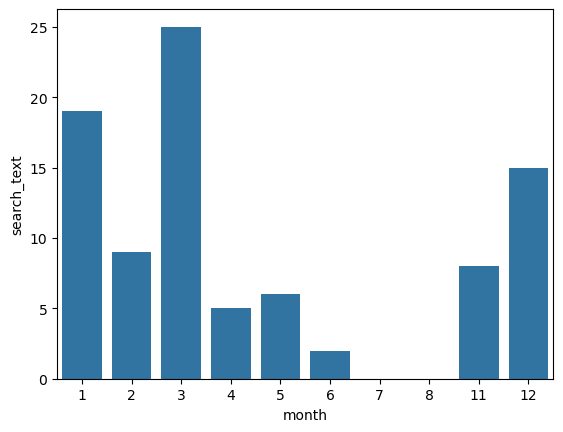

In [14]:
# render bar plot
ax = sns.barplot(x="month", y="search_text", data=result) #plot using seaborn
plt.show()

## Topic Modeling Tutorial

Now we are going to perform a technique called topic modeling, which enables us to identify themes in the text. For this, we will use a few tools, NLTK and sklearn.

In particular, we will use a method called, "Latent Dirichlet Allocation". We will specify the number of topics and the number of keywords that we want for each topic, and the algorithm will return that many topics, each with its associated set of keywords.

In [16]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [32]:
number_of_topics = 10
no_top_words = 10

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern=r"\w+|\$[\d\.]+|\S+")

In [22]:
# apply transformation
tf = vectorizer.fit_transform(entries['text']).toarray()

In [27]:
# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names_out()

In [28]:
from sklearn.decomposition import LatentDirichletAllocation

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [29]:
model.fit(tf)

LatentDirichletAllocation(random_state=0)

In [30]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [31]:
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,very,66.4,i,118.7,to,264.5,passed,233.3,of,127.8,wind,86.6,phrat,0.1,to,541.2,.,173.0,10,4.7
1,it,56.1,letter,63.6,i,260.2,passengers,205.0,in,124.7,of,63.9,satur,0.1,i,329.6,to,142.5,no,3.3
2,is,47.1,it,61.3,came,193.7,we,190.0,passengers,78.4,.,58.9,since,0.1,of,274.0,we,113.4,blosse,2.8
3,cloudy,38.9,a,56.4,called,170.3,.m.,165.9,amara,68.5,blowing,48.4,being,0.1,in,223.6,of,108.8,to,2.5
4,rain,35.0,to,56.3,went,160.7,.,156.7,we,66.5,a,45.2,time,0.1,a,220.6,in,96.3,very,2.4
5,are,24.6,very,56.2,.,132.7,weather,156.4,and,66.1,erly,37.4,april,0.1,is,199.7,passed,87.1,as,2.4
6,wind,21.6,went,45.5,we,111.8,landed,144.6,class,58.4,strong,36.0,wedn,0.1,he,195.7,a,73.6,passengers,2.2
7,still,21.5,is,44.6,of,110.8,5,130.3,with,56.4,to,34.2,clear,0.1,from,186.3,basreh,70.8,her,2.1
8,river,18.6,weather,42.8,home,107.0,and,129.9,.,47.4,s,33.7,khalifah,0.1,for,155.5,s,69.2,.,2.1
9,called,18.2,for,40.2,1,101.1,6,126.4,landed,46.1,we,33.0,baghdad,0.1,.,127.7,1,67.7,till,1.9
